# Fedbiomed to train a federated SGD regressor model

In [2]:
import os
os.chdir('/Users/fcremone/dev/fedbiomed/')

## Data 


This tutorial shows how to deploy in Fed-BioMed to solve a federated regression problem with scikit-learn.

In this tutorial we are using the wrapper of Fed-BioMed for the SGD regressor (https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html).
The goal of the notebook is to train a model on a realistic dataset of (synthetic) medical information mimicking the ADNI dataset (http://adni.loni.usc.edu/). 

## Creating nodes

To proceed with the tutorial, we create 3 clients with corresponding dataframes of clinical information in .csv format. Each client has 300 data points composed by several features corresponding to clinical and medical imaging informations. **The data is entirely synthetic and randomly sampled to mimick the variability of the real ADNI dataset**. The training partitions are availables at the following link:

https://drive.google.com/file/d/1R39Ir60oQi8ZnmHoPz5CoGCrVIglcO9l/view?usp=sharing

The federated task we aim at solve is to predict a clinical variable (the mini-mental state examination, MMSE) from a combination of demographic and imaging features. The regressors variables are the following features:

['SEX', 'AGE', 'PTEDUCAT', 'WholeBrain.bl', 'Ventricles.bl', 'Hippocampus.bl', 'MidTemp.bl', 'Entorhinal.bl']

and the target variable is:

['MMSE.bl']
    

To create the federated dataset, we follow the standard procedure for node creation/population of Fed-BioMed. 
After activating the fedbiomed network with the commands

`source ./scripts/fedbiomed_environment network`

and 

`./scripts/fedbiomed_run network`

we create a first node by using the commands

`source ./scripts/fedbiomed_environment node`

`./scripts/fedbiomed_run node start`

We then poulate the node with the data of first client:

`./scripts/fedbiomed_run node config conf.ini add`

Thn, we select option 1 (csv dataset) to add the .csv partition of client 1, by just picking the .csv of client 1. We use `adni` as tag to save the selected dataset. We can further check that the data has been added by executing `./scripts/fedbiomed_run node list`

Following the same procedure, we create the other two nodes with the datasets of client 2 and client 3 respectively. To do so, we add and launch a `Node`using others configuration files

### Set up data on the node

In [3]:
import sgkit as sg
from sgkit.io.vcf import vcf_to_zarr
import numpy as np
import pandas as pd
import xarray as xr
xr.set_options(display_expand_attrs=False, display_expand_data_vars=True);

In [4]:
from pathlib import Path
import requests

if not Path("1kg.vcf.bgz").exists():
    response = requests.get("https://storage.googleapis.com/sgkit-gwas-tutorial/1kg.vcf.bgz")
    with open("1kg.vcf.bgz", "wb") as f:
        f.write(response.content)

In [5]:
vcf_to_zarr("1kg.vcf.bgz", "1kg.zarr", max_alt_alleles=1,
          fields=["FORMAT/GT", "FORMAT/DP", "FORMAT/GQ", "FORMAT/AD"],
          field_defs={"FORMAT/AD": {"Number": "R"}})

[W::bcf_hdr_check_sanity] PL should be declared as Number=G


In [27]:
ds = sg.load_dataset("1kg.zarr")

In [28]:
ds = sg.sample_stats(ds)

Annotations

In [29]:
ANNOTATIONS_FILE = "https://storage.googleapis.com/sgkit-gwas-tutorial/1kg_annotations.txt"
df = pd.read_csv(ANNOTATIONS_FILE, sep="\t", index_col="Sample")

In [30]:
ds_annotations = pd.DataFrame.to_xarray(df).rename({"Sample":"samples"})
ds = ds.set_index({"samples": "sample_id"})
ds = ds.merge(ds_annotations, join="left")
ds = ds.reset_index("samples").reset_coords(drop=True)

sample level Quality Control

In [31]:
dp = ds.call_DP.where(ds.call_DP >= 0) # filter out missing
sample_dp_mean = dp.mean(dim="variants")
sample_dp_mean.attrs["long_name"] = "Mean Sample DP"
ds["sample_dp_mean"] = sample_dp_mean # add new data array to dataset

In [32]:
ds = ds.sel(samples=((ds.sample_dp_mean >= 4) & (ds.sample_call_rate >= 0.97)))
print(f"After filter, {len(ds.samples)}/284 samples remain.")

After filter, 250/284 samples remain.


Genotype QC

In [33]:
# fill rows with nan where no alternate alleles were read or where sum of reads is 0
ad1 = ds.call_AD.sel(dict(alleles=1)).pipe(lambda v: v.where(v >= 0))
adsum = ds.call_AD.sum(dim="alleles").pipe(lambda v: v.where(v != 0))
# compute alternate allele read fraction
ab = ad1 / adsum

In [34]:
GT = ds.call_genotype
hom_ref = (GT == 0).all(dim="ploidy")
het = GT[..., 0] != GT[..., 1]
hom_alt = ((GT > 0) & (GT[..., 0] == GT)).all(dim="ploidy")
filter_condition_ab = ((hom_ref & (ab <= 0.1)) |
                        (het & (ab >= 0.25) & (ab <= 0.75)) |
                        (hom_alt & (ab >= 0.9)))

In [35]:
GT = ds.call_genotype
hom_ref = (GT == 0).all(dim="ploidy")
het = GT[..., 0] != GT[..., 1]
hom_alt = ((GT > 0) & (GT[..., 0] == GT)).all(dim="ploidy")
filter_condition_ab = ((hom_ref & (ab <= 0.1)) |
                        (het & (ab >= 0.25) & (ab <= 0.75)) |
                        (hom_alt & (ab >= 0.9)))

In [36]:
filter_mask = xr.where(ds.call_genotype_mask, True, filter_condition_ab)
fraction_filtered = GT.where(~filter_mask).count().values / GT.size
print(f"Filtering {fraction_filtered * 100:.2f}% entries out of downstream analysis.")

Filtering 3.65% entries out of downstream analysis.


Variant QC

In [37]:
ds = sg.variant_stats(ds)
ds = sg.hardy_weinberg_test(ds)

/Users/fcremone/opt/anaconda3/envs/fedbiomed-researcher/lib/python3.9/site-packages/sgkit/utils.py:137: MergeWarning: The following variables in the input dataset will be replaced in the output: variant_n_het, variant_n_hom_alt, variant_n_hom_ref, variant_n_non_ref
  warnings.warn(


In [38]:
ds = ds.sel(variants=((ds.variant_allele_frequency[:,1] > 0.01) & (ds.variant_hwe_p_value > 1e-6)))
print(f"Samples: {len(ds.samples)}  Variants: {len(ds.variants)}")

Samples: 250  Variants: 8394


In [39]:
ds["call_dosage"] = ds.call_genotype.sum(dim="ploidy")

In [40]:
ds_pca = sg.stats.pca.count_call_alternate_alleles(ds)

In [41]:
# To run PCA we need to filter out variants with any missing alt allele counts
# Or where the counts are zero for all samples
variant_mask = ((ds_pca.call_alternate_allele_count < 0).any(dim="samples")) | \
    (ds_pca.call_alternate_allele_count.std(dim="samples") <= 0.0)
ds_pca = ds_pca.sel(variants=~variant_mask)

In [42]:
ds_pca = sg.pca(ds_pca)

In [43]:
ds["sample_pca_projection_0"] = ds_pca.sample_pca_projection[:,0]
ds["sample_pca_projection_1"] = ds_pca.sample_pca_projection[:,1]
ds["sample_pca_projection_2"] = ds_pca.sample_pca_projection[:,2]

To Pandas

In [44]:
genoptype_covariates_traits = [
    "call_dosage",
    "isFemale", "sample_pca_projection_0", "sample_pca_projection_1", "sample_pca_projection_2",
    "CaffeineConsumption"
]
df = ds[genoptype_covariates_traits].to_dataframe()

In [46]:
df.to_csv('data/1kg-preprocessed.csv')

Add dataset to node with tag '#1kg-preproc'

## Fed-BioMed Researcher

We are now ready to start the reseracher enviroment with the command `source ./scripts/fedbiomed_environment researcher`, and open the Jupyter notebook with `./scripts/fedbiomed_run researcher`. 

We can first query the network for the adni dataset. In this case, the nodes are sharing the respective partitions unsing the same tag `adni`:

In [47]:
%load_ext autoreload
%autoreload 2

In [48]:
import fedbiomed

In [87]:
from fedbiomed.researcher.requests import Requests
req = Requests()
req.list(verbose=True)

2022-05-06 13:23:23,695 fedbiomed INFO - Listing available datasets in all nodes... 
2022-05-06 13:23:33,710 fedbiomed INFO - 
 Node: node_093d3580-efe2-4741-86d5-371b6e3e3830 | Number of Datasets: 2 
+-------------------+-------------+------------------+---------------+--------------+
| name              | data_type   | tags             | description   | shape        |
+===================+=============+==================+===============+==============+
| csv test data     | csv         | ['#test_data']   |               | [1000, 16]   |
+-------------------+-------------+------------------+---------------+--------------+
| 1kgenomes-preproc | csv         | ['#1kg-preproc'] |               | [2098500, 8] |
+-------------------+-------------+------------------+---------------+--------------+



{'node_093d3580-efe2-4741-86d5-371b6e3e3830': [{'name': 'csv test data',
   'data_type': 'csv',
   'tags': ['#test_data'],
   'description': '',
   'shape': [1000, 16]},
  {'name': '1kgenomes-preproc',
   'data_type': 'csv',
   'tags': ['#1kg-preproc'],
   'description': '',
   'shape': [2098500, 8]}]}

The code for network and data loader of the sklearn SGDRegressor can now be deployed in Fed-BioMed.
We first import the necessary module `SGDSkLearnModel` from `fedbiomed`:

**__init__** : we add here the needed sklearn libraries
       
**training_data** : you must return here a tuple (data,targets) that must be of the same type of 
your method partial_fit parameters. 

We note that this model performs a common standardization across federated datasets by **centering with respect to the same parameters**.

In [107]:
from fedbiomed.common.training_plans import SGDSkLearnModel
from fedbiomed.common.data import DataManager

class SGDRegressorTrainingPlan(SGDSkLearnModel):
    def __init__(self, model_args: dict = {}):
        super(SGDRegressorTrainingPlan, self).__init__(model_args)
        self.variant_id = model_args['variant_id']
        self.add_dependency(["from sklearn.linear_model import SGDRegressor"])
    
    def training_data(self):
        dataset = pd.read_csv(self.dataset_path)
        dataset.set_index(['variants', 'samples'], inplace=True)
        
        G = dataset['call_dosage'].unstack().values
        X = np.ones(shape=(250,1))
        Q = np.linalg.qr(X)[0]
        Y = dataset['CaffeineConsumption'][0].values[:,np.newaxis]
        
        YP = Y - Q @ (Q.T @ Y)
        LS = Q @ (Q.T @ G.T)
        XLP = G.T - LS
        
        return DataManager(dataset=XLP[:,self.variant_id].reshape(-1,1), target=Y.ravel())
    
    def testing_step(self, *args, **kwargs):
        return 0.
    

**model_args** is a dictionary containing your model arguments, in case of SGDRegressor this will be max_iter and tol. n_features is provided to correctly initialize the SGDRegressor coef_ array.

**training_args** is a dictionary with parameters related to Federated Learning. 

In [118]:
from fedbiomed.common.metrics import MetricTypes
RANDOM_SEED = 1234


model_args = {
    'max_iter':1e+8,
    'tol': 1e-13,
#    'eta0':0.05,
    'model': 'SGDRegressor',
    'n_features': 1,
    'loss': 'squared_loss',
    'random_state': RANDOM_SEED,
    'variant_id':  0
}

training_args = {
    'epochs': 1,
    'test_ratio': 0.1,
    #'test_metric': MetricTypes.MEAN_SQUARE_ERROR,
    'test_on_local_updates': False,
    'test_on_global_updates': True
}

The experiment can be now defined, by providing the `adni` tag, and running the local training on nodes with model defined in `model_path`, standard `aggregator` (FedAvg) and `client_selection_strategy` (all nodes used). Federated learning is going to be perfomed through 10 optimization rounds.

In [115]:
from fedbiomed.researcher.experiment import Experiment
from fedbiomed.researcher.aggregators.fedavg import FedAverage

tags =  ['#1kg-preproc']

# Add more rounds for results with better accuracy
#
#rounds = 40
rounds = 400

# select nodes participating to this experiment
exp = Experiment(tags=tags,
                 model_args=model_args,
                 model_class=SGDRegressorTrainingPlan,
                 training_args=training_args,
                 round_limit=rounds,
                 aggregator=FedAverage(),
                 node_selection_strategy=None)

2022-05-06 13:45:12,262 fedbiomed INFO - Searching dataset with data tags: ['#1kg-preproc'] for all nodes
2022-05-06 13:45:22,268 fedbiomed INFO - Node selected for training -> node_093d3580-efe2-4741-86d5-371b6e3e3830
2022-05-06 13:45:22,274 fedbiomed DEBUG - Model file has been saved: /Users/fcremone/dev/fedbiomed/var/experiments/Experiment_0035/my_model_614df7ab-c877-4b30-8e7b-496fcb9a779d.py
2022-05-06 13:45:22,316 fedbiomed DEBUG - upload (HTTP POST request) of file /Users/fcremone/dev/fedbiomed/var/experiments/Experiment_0035/my_model_614df7ab-c877-4b30-8e7b-496fcb9a779d.py successful, with status code 201
2022-05-06 13:45:22,360 fedbiomed DEBUG - upload (HTTP POST request) of file /Users/fcremone/dev/fedbiomed/var/experiments/Experiment_0035/aggregated_params_init_7730ecf0-b487-4a2c-9ef7-3cee16f8b8b2.pt successful, with status code 201


In [116]:
# start federated training
exp.run()

2022-05-06 13:45:22,427 fedbiomed INFO - Sampled nodes in round 0 ['node_093d3580-efe2-4741-86d5-371b6e3e3830']
2022-05-06 13:45:22,428 fedbiomed INFO - Sending request 
					 To: node_093d3580-efe2-4741-86d5-371b6e3e3830 
					 Request: : Perform training with the arguments: {'researcher_id': 'researcher_8c105d0b-6bb7-4113-89b8-9b5af5f8bf5a', 'job_id': '3503f2ad-d9d7-4e01-9cec-e7d6cc2b8499', 'training_args': {'test_ratio': 0.1, 'test_on_local_updates': False, 'test_on_global_updates': True, 'test_metric': None, 'test_metric_args': {}, 'epochs': 1}, 'training': True, 'model_args': {'max_iter': 100000000.0, 'tol': 1e-13, 'model': 'SGDRegressor', 'n_features': 1, 'loss': 'squared_loss', 'random_state': 1234, 'verbose': 1}, 'command': 'train', 'model_url': 'http://localhost:8844/media/uploads/2022/05/06/my_model_614df7ab-c877-4b30-8e7b-496fcb9a779d.py', 'params_url': 'http://localhost:8844/media/uploads/2022/05/06/aggregated_params_init_7730ecf0-b487-4a2c-9ef7-3cee16f8b8b2.pt', 'model_cla

400

In [117]:
exp.aggregated_params()[0]['params']

{'intercept_': array([2.391595]), 'coef_': array([-0.11141256])}

##  Testing

Once the federated model is obtained, it is possible to test it locally on an independent testing partition.
The test dataset is available at this link:

https://drive.google.com/file/d/1zNUGp6TMn6WSKYVC8FQiQ9lJAUdasxk1/

In [11]:
!pip install matplotlib
!pip install gdown

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 19.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.9/930.9 KB 21.9 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.3/65.3 KB 3.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gdown: filename=gdown-4.4.0-py3-none-any.whl size=14775 sha256=1591b8a1643f903877eab59d3e802b3f6671dac848f55626ad9c02ed70cef8a8
  Stored in directory: /Users/fcremone/Library/Caches/pip/wheels/7d/37/b6/b2a79c75e898c0b8e46ff255102602d7159a10d9af0d80641a
Successfully built gdown


Download the testing dataset on the local temporary folder.

In [16]:
import os
import gdown
import tempfile
import zipfile

resource = "https://drive.google.com/uc?id=19kxuI146WA2fhcOU2_AvF8dy-ppJkzW7"
base_dir = tempfile.TemporaryDirectory(dir='.').name

if not os.path.exists(base_dir):
    os.makedirs(base_dir)

test_file = os.path.join(base_dir, "test_data.zip")
gdown.download(resource, test_file, quiet=False)

zf = zipfile.ZipFile(test_file)

for file in zf.infolist():
    zf.extract(file, base_dir)


Downloading...
From: https://drive.google.com/uc?id=19kxuI146WA2fhcOU2_AvF8dy-ppJkzW7
To: /Users/fcremone/dev/fedbiomed/notebooks/tmptg93hilc/test_data.zip
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12.4k/12.4k [00:00<00:00, 8.20MB/s]


In [17]:
import pandas as pd
import numpy as np


# loading testing dataset
test_data = pd.read_csv(os.path.join(base_dir,'adni_validation.csv'))

In [18]:
from sklearn.linear_model import SGDRegressor
import matplotlib.pyplot as plt

In [19]:
%matplotlib inline

Here we extract the relevant regressors and target from the testing data 

In [20]:
regressors_col = ['AGE', 'WholeBrain.bl', 'Ventricles.bl',
                  'Hippocampus.bl', 'MidTemp.bl', 'Entorhinal.bl']
target_col = ['MMSE.bl']
X_test = test_data[regressors_col].values
y_test = test_data[target_col].values

To inspect the model evolution across FL rounds, we export `exp.aggregated_params()` containing models parameters collected at the end of each round. The MSE (Mean Squarred Error) should be decreasing at each iteration with the federated parameters obtained at each round. 

Text(0, 0.5, 'testing loss (MSE)')

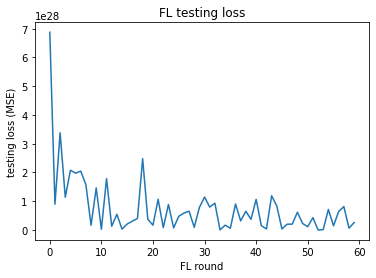

In [21]:
scaling_mean = np.array([0.8, 72.3, 16.2, 0.7, 0.0, 0.0])
scaling_sd = np.array([3.5e-01, 7.3e+00, 2.7e+00, 5.0e-02, 1.1e-02, 1.0e-03])

testing_error = []


# we create here several instances of SGDRegressor using same sklearn arguments
# we have used for Federated Learning training
fed_model = SGDRegressor()
regressor_args = {key: model_args[key] for key in model_args.keys() if key in fed_model.get_params().keys()}

for i in range(rounds):
    fed_model = SGDRegressor()
    fed_model.set_params(**regressor_args)
    fed_model.coef_ = exp.aggregated_params()[i]['params']['coef_'].copy()
    fed_model.intercept_ = exp.aggregated_params()[i]['params']['intercept_'].copy()  
    mse = np.mean((fed_model.predict((X_test-scaling_mean)/scaling_sd) - y_test)**2)
    testing_error.append(mse)

plt.plot(testing_error)
plt.title('FL testing loss')
plt.xlabel('FL round')
plt.ylabel('testing loss (MSE)')

We finally inspect the predictions of the final federated model on the testing data.

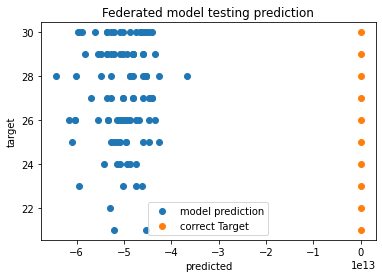

In [22]:
y_predicted = fed_model.predict((X_test-scaling_mean)/scaling_sd)
plt.scatter(y_predicted, y_test, label='model prediction')
plt.xlabel('predicted')
plt.ylabel('target')
plt.title('Federated model testing prediction')

first_diag = np.arange(np.min(y_test.flatten()),
                       np.max(y_test.flatten()+1))
plt.scatter(first_diag, first_diag, label='correct Target')
plt.legend()

In [23]:
a = X_test / scaling_sd
a.shape

(100, 6)

In [24]:
X_test.shape

(100, 6)

In [25]:
X_test[:,1] / scaling_sd[1] - a[:,1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])